# Emergency Response Shortest Path

**Project for *Selected Topics for Mathematical Optimization***

Professor Paul Van Liederke

### Contributors:
- Jihwan Lim
- Yunseol Park

## Introduction

In [222]:
import pandas as pd
import random
import math
import haversine
import matplotlib.pyplot as plt
import matplotlib
import datetime
from numpy import inf
from heapq import heapify, heappop, heappush

## Data
We generated a simulated city based off of real information from Seoul city, South Korea.

The city of Seoul is divided into smaller regions and the smallest administrative region is called *dong* (동), with each *dong* being around 0.2 to 12 $km^2$. There is 1 administrative office (주민센터) per *dong* and there are 426 of these in Seoul alone.

As mapping an entire city may be computationally challenging, we mapped these offices by their longitude and latitude to make the nodes of our graph. The data of this information was taken from the [Public Data Portal](https://www.data.go.kr/data/15059715/fileData.do).

In [12]:
def filter_data():
    '''
    Filters the data to have administrative office information

    Args:
        None
    Returns:
        loc_dict (dict): dictionary that has the dong name (ㅇㅇ구 ㅇㅇ동) as key and a tuple with the longitude and latitude as values
    '''
    # Read in data and only keep necessary columns
    city_df = pd.read_csv('data/전국공공시설개방정보표준데이터.csv', encoding='cp949')
    city_df = city_df[['관리기관명','개방시설명','개방장소명','위도','경도']]
    # Filter on Seoul city
    city_df = city_df[city_df['관리기관명'].str.contains('서울특별시')]
    # Some data are in the column 개방시설명 instead of 개방장소명
    ## Filter on 주민센터 then save the information in the column 개방장소명
    extra_df = city_df[city_df['개방시설명'].str.contains('주민센터')]
    extra_df = extra_df[~extra_df['개방장소명'].str.contains('주민센터')]
    extra_df['개방장소명'] = extra_df['개방시설명'].str.split('주민센터').str[0].str.strip()
    extra_df['개방장소명'] = extra_df['개방장소명'].str.split('구 ').str[-1]
    extra_df = extra_df.drop('개방시설명',axis=1).drop_duplicates()
    # The rest of the data are in the column 개방장소명 so drop 개방시설명
    city_df = city_df.drop(['개방시설명'], axis=1)
    city_df = city_df.dropna()      # Remove NA values
    ## Filter on 주민센터
    city_df = city_df[city_df['개방장소명'].str.contains('주민센터')]
    city_df['개방장소명'] = city_df['개방장소명'].str.split('주민센터').str[0].str.strip()
    city_df['개방장소명'] = city_df['개방장소명'].str.split('구 ').str[-1]
    # Concatinate the two dataframes together
    loc_df = pd.concat([city_df, extra_df])
    # Change the 관리기관명 column so that only the 구 name is in it
    loc_df['관리기관명'] = loc_df['관리기관명'].str.split().str[1]
    loc_df['관리기관명'] = loc_df['관리기관명'].str.replace('구청','구')
    # Remove duplicates
    loc_df = loc_df.drop_duplicates(subset=['관리기관명', '개방장소명'])
    # Make a new column that contains the columns 관리기관명 and 개방장소명
    loc_df['동'] = loc_df['관리기관명'] + ' ' + loc_df['개방장소명']
    # Convert the dataframe into dictionary with only the columns 동, 위도, 경도
    loc_dict = loc_df.set_index('동')[['경도', '위도']].apply(tuple, axis=1).to_dict()
    return loc_dict
loc_dict = filter_data()
loc_dict

{'노원구 중계4동': (127.077958, 37.658728),
 '노원구 상계1동': (127.054976, 37.679929843),
 '광진구 자양4동': (127.0662584, 37.53409779),
 '광진구 화양동': (127.0713179, 37.54653711),
 '광진구 군자동': (127.075486, 37.555495),
 '도봉구 쌍문2동': (127.0387508, 37.6580211),
 '도봉구 쌍문4동': (127.0283688, 37.6564188),
 '도봉구 쌍문3동': (127.0279086, 37.6489437),
 '도봉구 쌍문1동': (127.0260364, 37.6479992),
 '광진구 광장동': (127.1030098, 37.54688276),
 '광진구 자양1동': (127.0823949, 37.53449795),
 '광진구 자양2동': (127.0843875, 37.52879933),
 '광진구 자양3동': (127.0729024, 37.53383394),
 '광진구 중곡1동': (127.0800521, 37.56066762),
 '광진구 중곡2동': (127.0814751, 37.56015047),
 '광진구 중곡3동': (127.0801381, 37.56880689),
 '광진구 중곡4동': (127.0894329, 37.55909865),
 '광진구 능동': (127.0805521, 37.5537606),
 '광진구 구의1동': (127.0856773, 37.54241324),
 '광진구 구의2동': (127.0899239, 37.54724133),
 '광진구 구의3동': (127.0919847, 37.53799342),
 '도봉구 방학3동': (127.0279921, 37.6591413),
 '도봉구 방학1동': (127.0406367, 37.6641869),
 '도봉구 방학2동': (127.0350425, 37.668177),
 '도봉구 창1동': (127.0440451, 37.6485286

## Simulated city

From the data gathered, we randomly pick 10 as towns or households where the emergency events take place. We also pick some as hospitals or emergency rooms h(ERs). To do so, we make use of the actual ratio between ERs and administrative offices that are in Seoul. Then we also pick some as the emergency responders. Here, we take a third of the number of hospitals. Since the emergency events are set to be always medical in this project, and not other events, we require less responders than there are in reality.

In [13]:
# Get random example
random.seed(100)
keys_list = list(loc_dict.keys())
# List of random names to use for towns
towns = random.sample(keys_list, 10)
keys_list = [i for i in keys_list if i not in towns]
# List of random names to use as hospitals
ratio = 67/426
hospital = random.sample(keys_list, round(ratio*10))
keys_list = [i for i in keys_list if i not in hospital]
# List of random names to use as ambulance location / emergency services
ambulance = random.sample(keys_list, round(len(hospital)/3))
towns, hospital, ambulance

(['노원구 공릉1동',
  '서초구 방배2동',
  '서초구 방배1동',
  '강북구 수유2동',
  '강동구 둔촌2동',
  '관악구 청림동',
  '중랑구 묵1동',
  '성동구 사근동',
  '구로구 고척2동',
  '중랑구 신내1동'],
 ['중구 황학동', '송파구 잠실4동'],
 ['성동구 응봉동'])

### Generate graph

From the example from above, we now generate the graphs connecting the nodes. The connections are made randomly, to a random number of nodes between 1 to 3 for the households. For ERs and responders, we make the maximum number of connections to 4 nodes. As for the actual connections, we connect nodes based on the distance (i.e. the closer two nodes are, the more likely they will be connected).

As our data is on longitude and latitude information, we make use of *haversine* distance calculation to calculate the acutal distance between the two nodes and set these distances as the edges of the graph.

In [14]:
def make_paths(loc_dict, towns, hospital, ambulance):
    '''
    Function that connects the chosen nodes together.

    Args:
        loc_dict (dict): dictionary that has the dong name (ㅇㅇ구 ㅇㅇ동) as key and a tuple with the longitude and latitude as values
        towns (list): list of names of dong 
        hospital (list): list of names of hospitals 
        ambulance (list): list of names of emergency services
    Returns:
        connections (list): list of tuples that contain the haversine distance, and two names of nodes that are connected together
        graph_dict (dict): subset of 'loc_dict' that only contains the names given in 'towns' 'hospital' 'ambulance' lists
    '''
    # Get a list with all the nodes
    city = towns + hospital + ambulance
    connections = []
    graph_dict = {}
    for node in city:
        # List to save distances to all other nodes
        distance = []
        # Get lat and lon information of node
        x1, y1 = loc_dict[node]
        graph_dict[node] = loc_dict[node]       # Save to graph_dict
        # Choose how many other nodes it is connected to
        if node in towns:
            connect = random.randint(1,3)   # Random if it is a town
        else:
            # If it is in 'hospital' or 'ambulance' lists, then make the maximum connections
            connect = 4
        # If the node has already been connected to others, remove that number from 'connect'
        ## Only keep the number of connections that needs to be made
        counted = [i[1] for i in connections if node == i[1]]
        connect -= len(counted)
        # Loop over all the nodes to connect with
        for test in city:
            if connect == 0:    # Break loop if no connection is needed
                break
            if node == test:    # No need to calculate the distance in one node
                continue
            # Get lat and lon information of node
            x2, y2 = loc_dict[test]
            # Calculate haversine distance between the two (km)
            dist = haversine.distance((x1,y1),(x2,y2))
            distance.append((test, dist))
        # Sort the distances to the nodes and take the top n nodes (n=connect)
        con_city = sorted(distance, key=lambda x:x[1])[:connect+1]
        connections += [(i[1], node, i[0]) for i in con_city]       # Save the top nodes
    return connections, graph_dict

edges,graph_dict = make_paths(loc_dict, towns, hospital, ambulance)
edges, graph_dict

([(0.9794882745330652, '노원구 공릉1동', '중랑구 묵1동'),
  (3.1316406113826107, '노원구 공릉1동', '중랑구 신내1동'),
  (5.2679915636217185, '노원구 공릉1동', '성동구 사근동'),
  (6.136938121302798, '노원구 공릉1동', '강북구 수유2동'),
  (1.024426647939939, '서초구 방배2동', '서초구 방배1동'),
  (3.1016787600858513, '서초구 방배2동', '관악구 청림동'),
  (1.024426647939939, '서초구 방배1동', '서초구 방배2동'),
  (4.0304326582453225, '서초구 방배1동', '관악구 청림동'),
  (5.172734915454525, '강북구 수유2동', '중구 황학동'),
  (6.136938121302798, '강북구 수유2동', '노원구 공릉1동'),
  (6.290450788449695, '강북구 수유2동', '성동구 사근동'),
  (6.309078352520511, '강북구 수유2동', '성동구 응봉동'),
  (3.417168498763811, '강동구 둔촌2동', '송파구 잠실4동'),
  (6.779572221261132, '강동구 둔촌2동', '중랑구 신내1동'),
  (8.830580626071628, '강동구 둔촌2동', '중랑구 묵1동'),
  (3.1016787600858513, '관악구 청림동', '서초구 방배2동'),
  (4.0304326582453225, '관악구 청림동', '서초구 방배1동'),
  (8.617372755154378, '관악구 청림동', '중구 황학동'),
  (0.9794882745330652, '중랑구 묵1동', '노원구 공릉1동'),
  (2.380522606064914, '중랑구 묵1동', '중랑구 신내1동'),
  (1.4870596754203047, '성동구 사근동', '성동구 응봉동'),
  (2.75352718395044, '

The graph is then plotted.

Text(0, 0.5, 'latitude')

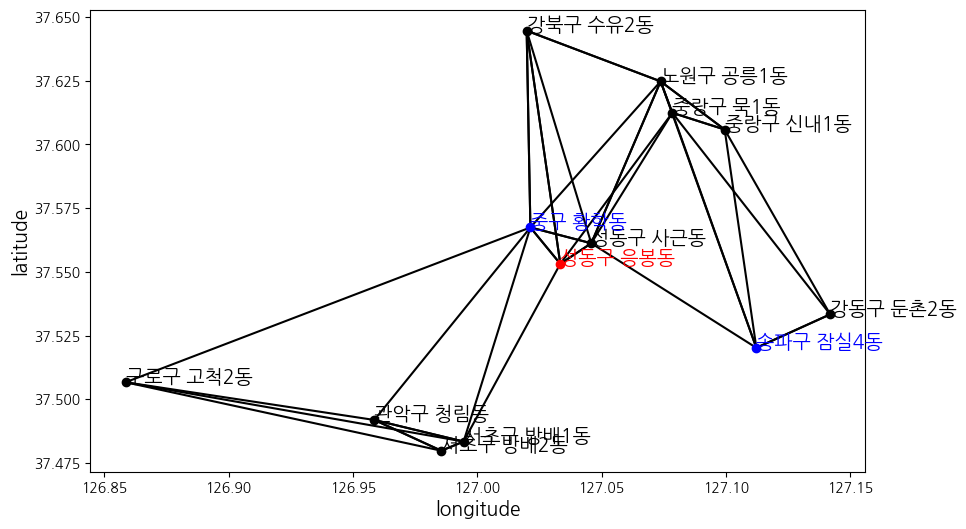

In [15]:
# Make a map of the graph
# Due to the names being KR, change font
path = "data/NanumGothic.ttf"
font_name = matplotlib.font_manager.FontProperties(fname=path).get_name()
plt.rcParams.update({'font.family':font_name})

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the nodes
for city, (lon, lat) in graph_dict.items():
    # Use different colors for different types of nodes
    if city in hospital:
        ax.scatter(lon, lat, color="blue", zorder=4)
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="blue")
    elif city in ambulance:
        ax.scatter(lon, lat, color="red", zorder=4)
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="red")
    else:
        ax.scatter(lon, lat, color="black", zorder=3)
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="black")

# Plot the edges
for w, c1, c2 in edges:
    x1, y1 = graph_dict[c1]
    x2, y2 = graph_dict[c2]
    plt.plot([x1,x2],[y1,y2], color='black', zorder=1)

ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)

The distances that we calculated above for the edges are now converted into travel times, and we also add traffic times as well. For the travel time, we assume the ambulance travels at the speed of 70 km/h as the speed limit of the city is usually 50 km/h [\[1\]](). The traffic decreases the speed of travel by 36% [\[2\]](), so that is how the traffic time is calculated.

In [16]:
def edges_to_graph(edges):
    """
    Transforms a set of edges in graphs with adjacenct nodes and travel time and traffic time.
    For UNDIRECTED graphs, i.e. if v2 in adj_list[v1], then v1 in adj_list[v2]
    Args:
        edges : a list of edges (tuple of distance and two nodes)
    Returns:
        adj_graph: nested dictionary that has the nodes as the primary keys and information on their
                   connected nodes and edges as value. The inner dictionary has the nodes that are connected
                   to the primary keys of the graph as key and the travel and traffic times in a dictionary as values
    """
    adj_graph = {}  # store in dictionary
    for w, v1, v2 in edges:
        # Ambulances average speed is ~70km/h
        t = math.ceil(w/70*60)  # In minutes
        add_dict = {'TravelTime': round(t,2), 'TrafficTime': round(t/0.36,2)-t}
        if v1 in adj_graph:  # edge already in it
            adj_graph[v1][v2] = add_dict
        else:
            adj_graph[v1] = {v2:add_dict}
        if v2 in adj_graph:  # edge already in it
            adj_graph[v2][v1] = add_dict
        else:
            adj_graph[v2] = {v1:add_dict}
    return adj_graph

adj_graph = edges_to_graph(edges)
adj_graph

{'노원구 공릉1동': {'중랑구 묵1동': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  '중랑구 신내1동': {'TravelTime': 3, 'TrafficTime': 5.33},
  '성동구 사근동': {'TravelTime': 5, 'TrafficTime': 8.89},
  '강북구 수유2동': {'TravelTime': 6, 'TrafficTime': 10.670000000000002},
  '중구 황학동': {'TravelTime': 6, 'TrafficTime': 10.670000000000002},
  '송파구 잠실4동': {'TravelTime': 8, 'TrafficTime': 14.219999999999999}},
 '중랑구 묵1동': {'노원구 공릉1동': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  '강동구 둔촌2동': {'TravelTime': 8, 'TrafficTime': 14.219999999999999},
  '중랑구 신내1동': {'TravelTime': 3, 'TrafficTime': 5.33},
  '성동구 사근동': {'TravelTime': 5, 'TrafficTime': 8.89},
  '송파구 잠실4동': {'TravelTime': 7, 'TrafficTime': 12.440000000000001},
  '성동구 응봉동': {'TravelTime': 6, 'TrafficTime': 10.670000000000002}},
 '중랑구 신내1동': {'노원구 공릉1동': {'TravelTime': 3, 'TrafficTime': 5.33},
  '강동구 둔촌2동': {'TravelTime': 6, 'TrafficTime': 10.670000000000002},
  '중랑구 묵1동': {'TravelTime': 3, 'TrafficTime': 5.33},
  '송파구 잠실4동': {'TravelTime': 6, 'T

## Shortes path for emergency responders

In [10]:
def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.

    Inputs:
            - previous : a dict with the previous node in the path
            - source : the source node
            - sink : the sink node
    Ouput:
            - the shortest path from source to sink
    """
    if sink not in previous:
        return []
    v = sink
    path = [v]
    while v is not source:
        v = previous[v] 
        path = [v] +path
    return path

In [179]:
def dijkstra(graph, source, sink, start_time, traffic_factor):
    """
    Implementation of Dijkstra's shortest path algorithm.

    Inputs:
        - graph : dict representing the weighted graph
        - source : the source node
        - sink : the sink node

    Ouput:
            - distance : dict with the distances of the nodes to the source
            - previous : dict with for each node the previous node in the
                        shortest path from the source (if one is given)
    """
    # keep tentative distance source to vertex
    # initialize with infinity, except for the source
    distance = {v : inf for v in graph.keys()}
    distance[source] = 0
    # keep previous node in path for backtracking
    previous = {}
    current_time = start_time
    # heap for vertices to check
    # priority based distance from source
    vertices_to_check = [(0, source, current_time)]   # zero indexing !
    N_vertices = 0            # number of visited vertices 

    while vertices_to_check:
        # pop vertex to explore
        # heappop() function removes and returns the smallest element from the heap
        dist, u, current_time = heappop(vertices_to_check)
        N_vertices +=1
        if u == sink:  # sink reached!
            break
        #print(u)
        #print(current_time)
        for node, edge in graph[u].items():
            travel_time = edge['TravelTime']
            traffic_time = edge['TrafficTime']
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
            new_time = travel_time + current_traffic
            new_dist = dist + new_time
            #print('calculate', node, new_dist)
            if new_dist < distance[node]:
                distance[node] = new_dist                  
                previous[node] = u
                #print(node, datetime.timedelta(minutes=new_time))
                add_time = current_time + datetime.timedelta(minutes=new_time)             
                heappush(vertices_to_check, (new_dist, node, add_time))
        #print(vertices_to_check)
                
    if sink is None:
        return distance, previous, N_vertices, current_time - start_time
    else:
        return reconstruct_path(previous, source, sink), distance[sink], N_vertices, current_time - start_time

In [91]:
traffic_factor = {'weekday': {}, 'weekend': {}}
for k in range(0,24):
    if k in range(0,7):
        traffic_factor['weekday'][k] = 0.1
        traffic_factor['weekend'][k] = 0.1
    elif k in range(7,9):
        traffic_factor['weekday'][k] = 0.8
        traffic_factor['weekend'][k] = 0.5
    elif k in range(11,13):
        traffic_factor['weekday'][k] = 0.5
        traffic_factor['weekend'][k] = 0.5
    elif k in range(17,19):
        traffic_factor['weekday'][k] = 0.8
        traffic_factor['weekend'][k] = 0.5
    elif k in range(19,24):
        traffic_factor['weekday'][k] = 0.5
        traffic_factor['weekend'][k] = 0.5
    else:
        traffic_factor['weekday'][k] = 0.3
        traffic_factor['weekend'][k] = 0.3

### Generate random example

The below is an example for only one emergency event. This should be changed to multiple (and even simultaneous events).

In [211]:
random.seed(14)
source = random.choice(towns)
source

'서초구 방배2동'

### Find the shortest path from emergency responder to household

In [230]:
day = datetime.datetime(2023,6,10,15,00)
print('starting time: {}'.format(day))
am_to_town = ['', datetime.timedelta(seconds=86400), 0]
for start in ambulance:
    distance, previous, vertices, time_difference = dijkstra(adj_graph, start, source, day, traffic_factor)
    #print(distance, vertices, previous)
    #print(time_difference)
    if am_to_town[1] > time_difference:
        am_to_town = [distance, time_difference, len(distance)]
    elif am_to_town[1] == time_difference:
        if am_to_town[2] > len(distance):
            am_to_town = [distance, time_difference, len(distance)]
print('shortes path: {}'.format(am_to_town[0]))
print('time needed for the shortest path: {} minutes and {} seconds'.format(am_to_town[1].total_seconds()//60, am_to_town[1].total_seconds()%60))
starting_ambulance = am_to_town[0][0]
print('chosen emergency responder for shortes path: {}'.format(starting_ambulance))

starting time: 2023-06-10 15:00:00
2023-06-10 15:00:00
shortes path: ['성동구 응봉동', '서초구 방배1동', '서초구 방배2동']
time needed for the shortest path: 10.0 minutes and 44.10000000000002 seconds
chosen emergency responder for shortes path: 성동구 응봉동


### Find the shortest path from household to ER

In [231]:
day += closest[1]
print('starting time: {}'.format(day))
town_to_hos = ['', datetime.timedelta(seconds=86400), 0]
for sink in hospital:
    distance, previous, vertices, time_difference = dijkstra(adj_graph, source, sink, day, traffic_factor)
    #print(distance, vertices, previous)
    #print(time_difference)
    if town_to_hos[1] > time_difference:
        town_to_hos = [distance, time_difference, len(distance)]
    elif town_to_hos[1] == time_difference:
        if town_to_hos[2] > len(distance):
            town_to_hos = [distance, time_difference, len(distance)]
print('shortest path: {}'.format(town_to_hos[0]))
print('time needed for the shortes path: {} minutes and {} seconds'.format(town_to_hos[1].total_seconds()//60, town_to_hos[1].total_seconds()%60))
starting_ambulance = town_to_hos[0][0]
print('chosen emergency responder for shortes path: {}'.format(starting_ambulance))

starting time: 2023-06-10 15:21:28.200000
2023-06-10 15:21:28.200000
2023-06-10 15:21:28.200000
shortest path: ['서초구 방배2동', '서초구 방배1동', '중구 황학동']
time needed for the shortes path: 10.0 minutes and 44.10000000000002 seconds
chosen emergency responder for shortes path: 서초구 방배2동


In [229]:
closest = [i+j for i,j in zip(am_to_town, town_to_hos)]
print('shortest path: {}'.format(closest[0]))
print('time needed for the shortes path: {} minutes and {} seconds'.format(closest[1].total_seconds()//60, closest[1].total_seconds()%60))

shortest path: ['성동구 응봉동', '서초구 방배1동', '서초구 방배2동', '서초구 방배2동', '서초구 방배1동', '중구 황학동']
time needed for the shortes path: 21.0 minutes and 28.200000000000045 seconds


MovieWriter imagemagick unavailable; using Pillow instead.


['성동구 응봉동', '서초구 방배1동', '서초구 방배2동', '서초구 방배2동', '서초구 방배1동', '중구 황학동']


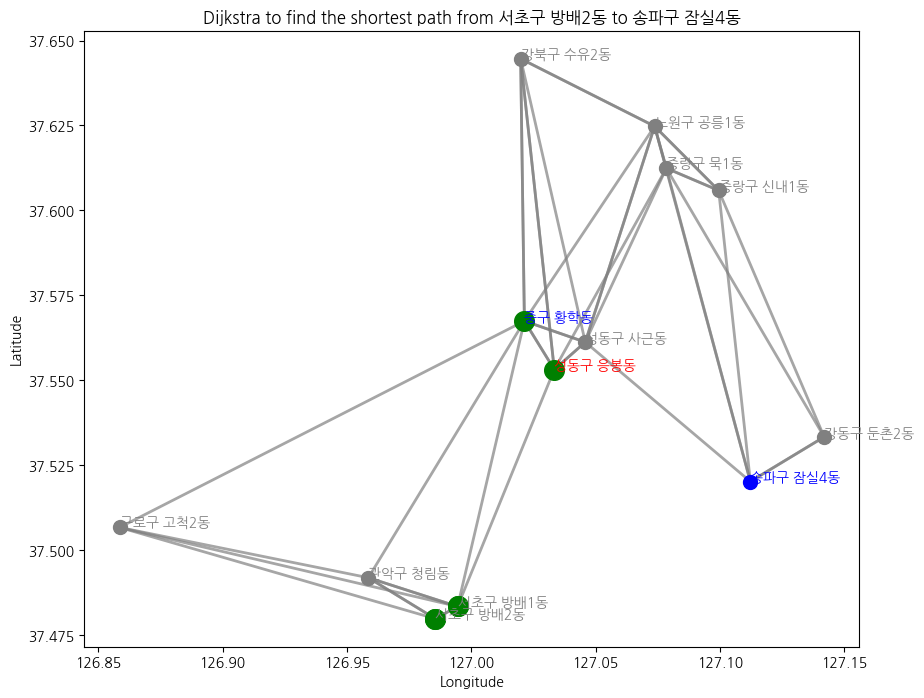

In [221]:
#make animation
from matplotlib.animation import FuncAnimation

def make_shortest_path_animation(coordinates, edges, order, fig, ax,
                                pointsize=100):
    # make animation of the shortest path algorithms
    for w, i, j in edges:
        xi1, xi2 = coordinates[i]
        xj1, xj2 = coordinates[j]
        ax.plot([xi1, xj1], [xi2, xj2], color='grey', alpha=0.7, lw=2, zorder=1)

    # plot points
    for city, (lon, lat) in coordinates.items():
        # Use different colors for different types of nodes
        if city in hospital:
            ax.scatter(lon, lat, color="blue", s=pointsize, zorder=2)
            ax.text(lon, lat, city, fontsize=10, zorder=5, color="blue")
        elif city in ambulance:
            ax.scatter(lon, lat, color="red", s=pointsize, zorder=2)
            ax.text(lon, lat, city, fontsize=10, zorder=5, color="red")
        else:
            ax.scatter(lon, lat, color="grey", s=pointsize, zorder=2)
            ax.text(lon, lat, city, fontsize=10, zorder=5, color="grey")
    '''print(order)
    # color source (first) and sink (last)
    x1, x2 = coordinates[order[0]]
    ax.scatter(x1, x2, color="blue", s=pointsize, zorder=3)
    x1, x2 = coordinates[order[-1]]
    ax.scatter(x1, x2, color="red", s=pointsize*2, zorder=3) '''

    # make animation
    anim = FuncAnimation(fig, lambda t : ax.scatter(*coordinates[order[t-1]],
                                color="green", s=pointsize*2, zorder=4) if t else None,
                                frames=range(len(order)+1), interval=500)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return anim

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Dijkstra to find the shortest path from {} to {}'.format(source, sink))
anim = make_shortest_path_animation(graph_dict, edges, closest[0], fig, ax)
anim.save('Dijkstra_animated.gif', dpi=120, writer='imagemagick')

## A star algorithm for later

In [143]:
# STMO-P7
# heuristic: haversine (lat&lon)

def a_star(graph, source, sink, heuristic, traffic_factor):
    """
    Implementation of the A* shortest path algorithm
    Inputs:
        - graph : dict representing the graph
        - source : the source node
        - sink : the sink node (optional)
        - heuristic : a function with the heuristic for the shortest path between two nodes
    Ouput:
        - distance : dict with the distances of the nodes to the source
        - came_from : dict with for each node the previous node in the shortest
                    path from the source
    """
    # keep tentative distance source to vertex
    # initialize with infinity, except for the source
    distance = {v : inf for v in graph.keys()}
    distance[source] = 0
    # keep previous node in path for backtracking
    previous = {}
    # vertices_to_check is a heap using the estimated distance
    # of a given node to a source as the priority
    vertices_to_check = [(heuristic(source, sink), source)]             #complete
    previous = {}
    N_vertices = 0

#complete below (you can start from the Dijkstra algorithm)    
    while vertices_to_check:
        heuristic_dis, current = heappop(vertices_to_check)
        if current == sink:
            return reconstruct_path(previous, source, sink), distance[sink]
        for dist_current_neighbor, neighbor in graph[current]:
            travel_time = neighbor['TravelTime']
            traffic_time = neighbor['TrafficTime']
            new_dist_from_source = distance[current] + dist_current_neighbor
            if new_dist_from_source < distance[neighbor]:
                min_dist_neighbor_source = distance[neighbor] + heuristic(neighbor, sink)
                heappush(vertices_to_check, min_dist_neighbor_source, neighbor)
                previous[neighbor] = current

In [55]:
# Example
graph = {
    'A': {'B': {'travelTime': 10, 'trafficTime': 2}, 'C': {'travelTime': 5, 'trafficTime': 1}},
    'B': {'C': {'travelTime': 8, 'trafficTime': 3}},
    'C': {'D': {'travelTime': 6, 'trafficTime': 2}},
    'D': {'E': {'travelTime': 4, 'trafficTime': 1}},
    'E': {}
}

def AStarWithTraffic(graph, start, goal, traffic_factor):
    openSet = []
    openSet.append((0, start))
    cameFrom = {}
    gScore = {}
    gScore[start] = 0
    fScore = {}
    fScore[start] = heuristic(start, goal)

    while openSet:
        current = min(openSet, key=lambda x: fScore[x[1]])
        openSet.remove(current)

        if current[1] == goal:
            return reconstructPath(cameFrom, current[1])

        for neighbor in graph.neighbors(current[1]):
            edge = graph.get_edge(current[1], neighbor)
            travelTime = edge.travelTime
            trafficTime = edge.trafficTime
            # Assume trafficTime is the additional time due to traffic conditions

            # Calculate the tentative gScore and fScore for the neighbor
            tentative_gScore = gScore[current[1]] + (travelTime + traffic_factor * trafficTime)
            tentative_fScore = tentative_gScore + heuristic(neighbor, goal)

            if neighbor not in gScore or tentative_gScore < gScore[neighbor]:
                cameFrom[neighbor] = current[1]
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = tentative_fScore

                if neighbor not in [node[1] for node in openSet]:
                    openSet.append((tentative_fScore, neighbor))

    return None  # No path found


'''In this updated version, we assume that the edge object has a new attribute trafficTime, which represents the additional time required due to traffic conditions along that edge. The traffic_factor is a parameter that you can adjust to control the influence of traffic on the estimated travel time.

The tentative gScore is calculated by adding the base travel time (travelTime) and the traffic-adjusted time (traffic_factor * trafficTime) to the previous gScore. This ensures that the algorithm considers the traffic conditions when determining the shortest path.

Please note that the exact implementation may depend on the specific structure of your graph and the representation of edge data. Adjust the code accordingly based on your graph implementation.
'''

'In this updated version, we assume that the edge object has a new attribute trafficTime, which represents the additional time required due to traffic conditions along that edge. The traffic_factor is a parameter that you can adjust to control the influence of traffic on the estimated travel time.\n\nThe tentative gScore is calculated by adding the base travel time (travelTime) and the traffic-adjusted time (traffic_factor * trafficTime) to the previous gScore. This ensures that the algorithm considers the traffic conditions when determining the shortest path.\n\nPlease note that the exact implementation may depend on the specific structure of your graph and the representation of edge data. Adjust the code accordingly based on your graph implementation.\n'

# References

1. Pappinen, J., & Nordquist, H. (2022). Driving Speeds in Urgent and Non-Urgent Ambulance Missions during Normal and Reduced Winter Speed Limit Periods-A Descriptive Study. Nursing reports (Pavia, Italy), 12(1), 50–58. https://doi.org/10.3390/nursrep12010006
2. Seoul Metropolitan City (2022). 2022 Report of Traffic Speeds in Seoul Metropolitan City. 51-6110000-002492-10 (https://topis.seoul.go.kr/refRoom/openRefRoom_1.do)